<center><b>Proyecto 4</b></center>
<center><i>Informe Final</i></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()

In [2]:
df = pd.read_csv('C:/Users/Usuario/Downloads/DS_Proyecto_01_Datos_Properati.csv')
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


<b>Planteamiento del problema</b>

Para este proyecto se utilizará el modelo ARIMA para capturar el componente estacional de los datos de propiedades que se utilizaron para los proyctos 1 y 2. 

<b>Filtro y ajuste a ST</b>

Para realizar el modelo, se aplicará el filtro que se utilizó en el segundo proyecto pero sólo se analizará los precios de la propiedad horizontal.

In [3]:
df2 = df[df['surface_total'] > df['surface_covered']]
df2 = df2[(df2['l2'] == "Capital Federal") & (df2.property_type.isin(['PH']))]

In [4]:
df2['fecha'] = pd.to_datetime(df2.created_on)
df2.drop(columns=['end_date','start_date', 'property_type'], inplace = True)

In [8]:
df2.set_index('created_on', inplace=True)
df2.index

Index(['2019-10-17', '2019-10-17', '2019-10-17', '2019-10-17', '2019-10-17',
       '2019-10-17', '2019-10-17', '2019-10-17', '2019-10-17', '2019-10-17',
       ...
       '2019-07-31', '2019-07-31', '2019-07-31', '2019-07-31', '2019-07-31',
       '2019-07-31', '2019-07-31', '2019-07-31', '2019-07-31', '2019-07-31'],
      dtype='object', name='created_on', length=5803)

In [9]:
ts = df2['price']
ts.head()

created_on
2019-10-17    159000.0
2019-10-17    295000.0
2019-10-17     89000.0
2019-10-17     89000.0
2019-10-17    170000.0
Name: price, dtype: float64

<b>Análisis expolatorio de datos</b>

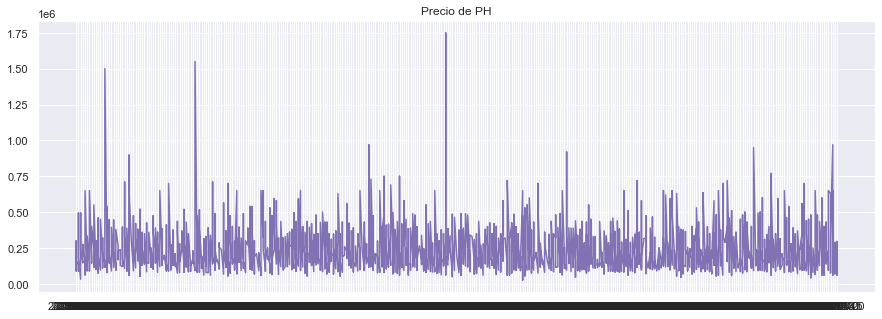

In [16]:
plt.figure(figsize = (15,5))
plt.plot(ts, c='m')
plt.title('Precio de PH')
plt.show()

<b>Planteamiento del modelo</b>



In [32]:
from statsmodels.tsa.stattools import adfuller
rolmean = ts.rolling(12).mean()
rolstd = ts.rolling(12).std()    

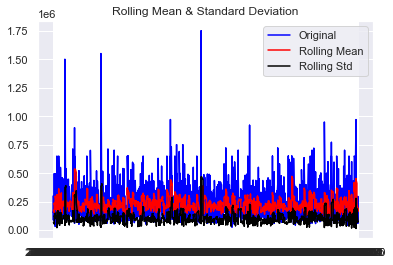

In [33]:
plt.plot(ts, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Para evaluar si la base de datos es estacionaria, se aplica el test de Dickey-Fuller aumentado. 

In [34]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -26.044184
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5798.000000
Critical Value (1%)              -3.431478
Critical Value (5%)              -2.862039
Critical Value (10%)             -2.567035
dtype: float64


El `p-value` al ser menor a 0.05 significa que la serie es estacionaria. Antes de plantear el modelo, se realizará imputación de los valores nulos de las variables `surface_total` y `bathrooms`

In [35]:
df2['bathrooms'].fillna(df2['bathrooms'].mean(), inplace = True)

In [38]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


(-0.5, 0.5)

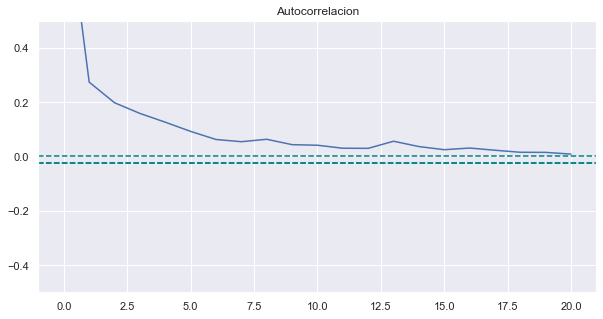

In [48]:
plt.figure(figsize = (10,5))
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='teal')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='teal')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='teal')
plt.title('Autocorrelacion')
plt.ylim(-0.5,0.5)

(-0.5, 0.5)

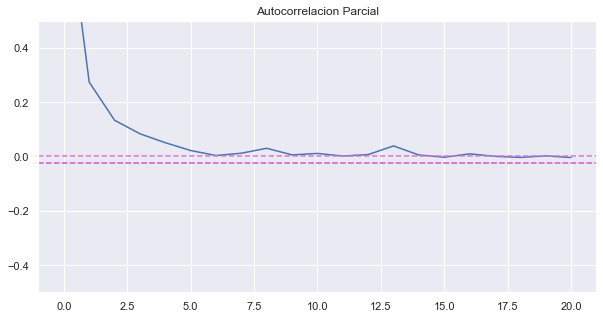

In [49]:
plt.figure(figsize = (10,5))
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='orchid')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='orchid')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle='--', color='orchid')
plt.title('Autocorrelacion Parcial')
plt.ylim(-0.5,0.5)

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so w

2.6347898610440184e+16


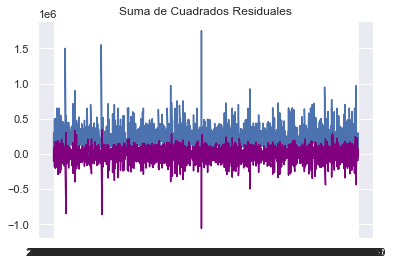

In [67]:
#Modelo AR, q=0
model = ARIMA(ts, order= (5, 1, 0))
results_ARIMA = model.fit(disp= -1)
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color='purple')
plt.title('Suma de Cuadrados Residuales')
RSS = sum((results_ARIMA.fittedvalues - ts)**2)
print(RSS)

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so w

2.7975751791341816e+16


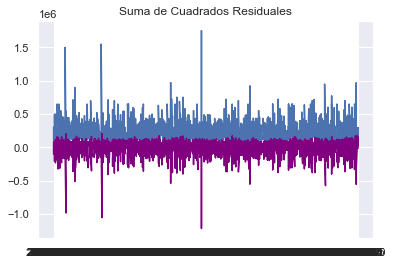

In [70]:
#Modelo MA, p=0
model = ARIMA(ts, order= (0, 1, 5))
results_ARIMA = model.fit(disp= -1)
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color='purple')
plt.title('Suma de Cuadrados Residuales')
RSS = sum((results_ARIMA.fittedvalues - ts)**2)
print(RSS)

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so w

2.798400923024262e+16


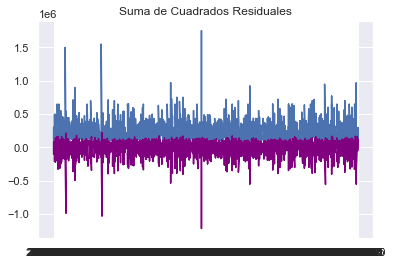

In [71]:
#Modelo ARIMA, p=5 y q=5
model = ARIMA(ts, order= (5, 1, 5))
results_ARIMA = model.fit(disp= -1)
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color='purple')
plt.title('Suma de Cuadrados Residuales')
RSS = sum((results_ARIMA.fittedvalues - ts)**2)
print(RSS)

De acuerdo a los resultados de las sumas de cuadrados residuales, el modelo AR tiene los mejores resultados al tener la suma de cuadrados menor.

In [75]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA.head()

created_on
2019-10-17        5.310392
2019-10-17   -60923.351996
2019-10-17    79939.314262
2019-10-17    54874.896094
2019-10-17   -14429.084455
dtype: float64

RMS: 86402.62523378084


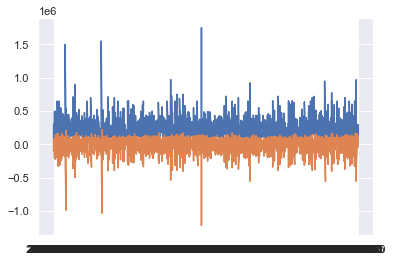

In [78]:
plt.plot(ts)
plt.plot(predictions_ARIMA)
RMS = np.sqrt(sum((predictions_ARIMA)**2/len(ts)))
print('RMS:', RMS)

<b>Conclusiones</b>

El uso del modelo ARIMA disminuyó el valor de `RMSE` en comparación al de los modelos de los proyectos 1 y 2. Este valor podría disminiur más si se eliminan los outliers.